In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import urllib
import ssl

context=ssl._create_unverified_context()

eulerfile=urllib.URLopener(context=context)
eulerfile.retrieve('https://matin.gatech.edu/resources/61/download/euler_all.hdf5', 'euler_all.hdf5')
print "microstructure data retrieved"

responsesfile=urllib.URLopener(context=context)
responsesfile.retrieve('https://matin.gatech.edu/resources/62/download/responses_all.hdf5', 'responses_all.hdf5')
print "response data retrieved"

microstructure data retrieved
response data retrieved


Load the euler angles for each microstructure class

In [3]:
import h5py
import numpy as np

n_class = 12
ns = 20
el = 21
ns_tot = n_class*ns

euler = np.zeros((ns_tot, 3, el**3))

f = h5py.File('euler_all.hdf5', 'r')

c = 0
for name in f.keys():
    euler[c:c+ns, ...] = f.get(name)[...]
    c += ns

f.close()

Load the responses for each microstructure class

In [4]:
y_st = np.zeros((ns_tot,))
y_ys = np.zeros((ns_tot,))

f = h5py.File('responses_all.hdf5', 'r')

c = 0
d = 0
for name in f.keys():
    if 'modulus' in name:
        y_st[c:c+ns, ...] = f.get(name)[...]
        c += ns
    elif 'strength' in name:
        y_ys[d:d+ns, ...] = f.get(name)[...]
        d += ns
    else:
        print "unexpected array detected"
        
f.close()

Return Bunge-Euler angles to the first fundamental zone (FZ) for hexagonal crystal symmetry.

Hexagonal FZ: [0<=phi1<360, 0<=Phi<=90 , 0<=phi2<60]

In [5]:
import euler_func as ef

symop = ef.symhex()
n_sym = symop.shape[0]
print "number of symmetry operators: %s" % n_sym

euler_ = euler.swapaxes(1, 2)

n_tot = ns_tot*el**3
euler_ = euler_.reshape((n_tot, 3))

euler_sym = np.zeros((n_sym, n_tot, 3))

g_orig = ef.bunge2g(euler_[:, 0], euler_[:, 1], euler_[:, 2])

# find the symmetric equivalents to the euler angle within the FZ
for sym in xrange(n_sym):
    op = symop[sym, ...]

    # g_sym: array of orientation matrices transformed with a
    # symmetry operator
    g_sym = np.einsum('ik,...kj', op, g_orig)

    tmp = np.array(ef.g2bunge(g_sym)).transpose()

    if sym == 0:
        print "g_sym shape: %s" % str(g_sym.shape)
        print "tmp shape: %s" % str(tmp.shape)

    del g_sym
    euler_sym[sym, ...] = tmp
    del tmp

# make sure all of the euler angles within the appropriate
# ranges (eg. not negative)
print "initial: euler angles less than zero: %s" % np.sum(euler_sym < 0)
lt = euler_sym < 0.0

euler_sym += 2*np.pi*lt
print "final: euler angles less than zero: %s" % np.sum(euler_sym < 0)

number of symmetry operators: 12
g_sym shape: (2222640L, 3L, 3L)
tmp shape: (2222640L, 3L)
initial: euler angles less than zero: 26671200
final: euler angles less than zero: 0


In [6]:
# identify euler angle sets w/in first FZ
tmp1 = euler_sym[..., 0] < 2.*np.pi
tmp2 = euler_sym[..., 1] <= np.pi/2.
tmp3 = euler_sym[..., 2] < np.pi/3.
indxs = tmp1*tmp2*tmp3

# when there are multiple in the first FZ only pick one
tmp4 = np.sum(indxs, axis=0) == 1 
tmp4n = np.sum(indxs, axis=0) > 1

indxs = indxs*tmp4
indxs[0, tmp4n] = 1

indxs2 = np.sum(indxs * np.arange(12)[:, None], axis=0)

Convert Euler angles from radians to degrees

In [7]:
X_eul = euler_sym[indxs2,np.arange(indxs2.size),:]
X_eul = X_eul.reshape((ns_tot, el, el, el, 3))*(180./np.pi)

print X_eul[..., 0].min()
print X_eul[..., 0].max()
print X_eul[..., 1].min()
print X_eul[..., 1].max()
print X_eul[..., 2].min()
print X_eul[..., 2].max()


0.0
359.983071149
0.0
89.9997925898
0.0
59.9976844143


Bin Euler angles to approximate polycrystalline microstructure as a composite microstructure.

In [8]:
degp1 = 45
degP = 45
degp2 = 30

p1max = 360
Pmax = 90
p2max = 60

np1 = p1max/degp1
nP = Pmax/degP
np2 = p2max/degp2

nbin = np1*nP*np2

X = np.zeros((ns_tot, el, el, el))

for ii in xrange(nbin):
    ip1, iP, ip2 = np.unravel_index(ii, (np1, nP, np2))
    
    tmp0a = X_eul[..., 0] >= ip1*degp1
    tmp0b = X_eul[..., 0] < (ip1+1)*degp1
    tmp1a = X_eul[..., 1] >= iP*degP
    tmp1b = X_eul[..., 1] < (iP+1)*degP
    tmp2a = X_eul[..., 2] >= ip2*degp2
    tmp2b = X_eul[..., 2] < (ip2+1)*degp2
    
    tmp = tmp0a*tmp0b*tmp1a*tmp1b*tmp2a*tmp2b
    
    X += ii*tmp

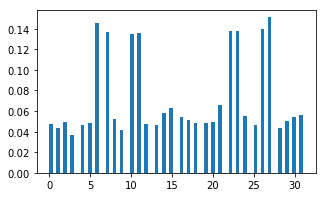

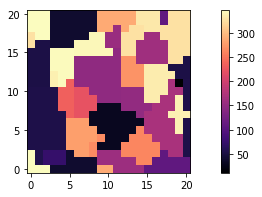

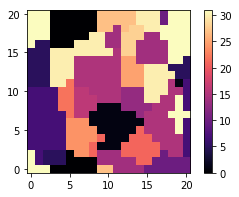

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=[5, 3])
tmp = X.reshape(X.size)
n, bins, patches = plt.hist(X.reshape(X.size), 72, normed=1)

plt.figure(figsize=[11, 3])
ax = plt.imshow(X_eul[0, 0, :, :, 0], origin='lower',
                    interpolation='none', cmap='magma')
plt.colorbar(ax)

plt.figure(figsize=[5, 3])
ax = plt.imshow(X[0, 0, :, :], origin='lower',
                interpolation='none', cmap='magma')
plt.colorbar(ax)

In [10]:
# obtain training and test sets of MVEs

nc = 5
nv = 5

X_cal = np.zeros((nc*n_class, el, el, el))
y_st_cal = np.zeros((nc*n_class,))
y_ys_cal = np.zeros((nc*n_class,))

X_val = np.zeros((nv*n_class, el, el, el))
y_st_val = np.zeros((nv*n_class,))
y_ys_val = np.zeros((nv*n_class,))

for ii in xrange(n_class):
    X_cal[ii*nc:(ii+1)*nc,...] = X[ii*ns:(ii*ns)+nc,...]
    y_st_cal[ii*nc:(ii+1)*nc] = y_st[ii*ns:(ii*ns)+nc]
    y_ys_cal[ii*nc:(ii+1)*nc] = y_ys[ii*ns:(ii*ns)+nc]

    X_val[ii*nv:(ii+1)*nv,...] = X[(ii*ns)+nc:(ii*ns)+nc+nv,...]
    y_st_val[ii*nv:(ii+1)*nv] = y_st[(ii*ns)+nc:(ii*ns)+nc+nv]
    y_ys_val[ii*nv:(ii+1)*nv] = y_ys[(ii*ns)+nc:(ii*ns)+nc+nv]

In [11]:
from pymks import PrimitiveBasis
from pymks.stats import correlate
from scipy.stats import mode

#identify highest volume fraction bin:
md = np.int32(mode(X_cal.reshape(X_cal.size))[0])
print "most common bin :" + str(md)

#define which correlations to compute
correlations=[]
for ii in xrange(nbin-1):
    correlations.append((ii, ii))

prim_basis = PrimitiveBasis(n_states=nbin, domain=(0,nbin-1))

#compute using loop to avoid memory issues
corr_cal = np.zeros((X_cal.shape[0], el, el ,el, len(correlations)))
for ii in xrange(X_cal.shape[0]):
    corr_cal[ii,...] = correlate(X_cal[ii,...], prim_basis, correlations=correlations)
print "correlations for training set computed"
    
    
corr_val = np.zeros((X_val.shape[0], el, el ,el, len(correlations)))
for ii in xrange(X_val.shape[0]):
    corr_val[ii,...] = correlate(X_val[ii,...], prim_basis, correlations=correlations)
print "correlations for test set computed"

most common bin :27
correlations for training set computed
correlations for test set computed


In [12]:
print len(correlations)
correlate(X_cal[0,...], prim_basis, correlations=correlations).shape

31


(21L, 21L, 21L, 31L)

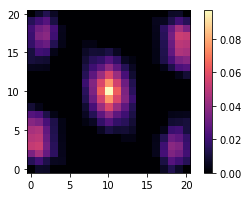

In [26]:
plt.figure(figsize=[5, 3])
ax = plt.imshow(corr_val[0, 10, :, :, 5], origin='lower',
                interpolation='none', cmap='magma')
plt.colorbar(ax)

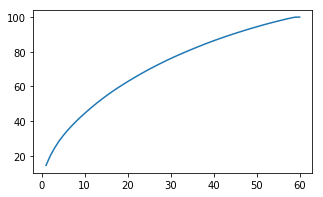

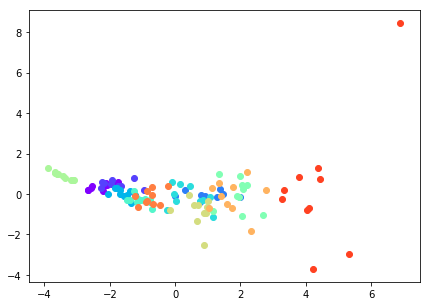

In [14]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

pca = PCA()
pca.fit(corr_cal.reshape(nc*n_class, (nbin-1)*el**3))

plt.figure(figsize=[5, 3])
cev = np.cumsum(pca.explained_variance_ratio_)*100
plt.plot(np.arange(cev.size)+1, cev)

red_cal = pca.transform(corr_cal.reshape(nc*n_class, (nbin-1)*el**3))
red_val = pca.transform(corr_val.reshape(nv*n_class, (nbin-1)*el**3))

plt.figure(figsize=[7, 5])

for ii in xrange(n_class):
    d1 = ii*nc
    d2 = (ii+1)*nc
    e1 = ii*nv
    e2 = (ii+1)*nv
    c = cm.rainbow(ii/np.float16(n_class))
    plt.scatter(red_cal[d1:d2, 0], red_cal[d1:d2, 1], c=c)
    plt.scatter(red_val[e1:e2, 0], red_val[e1:e2, 1], c=c)

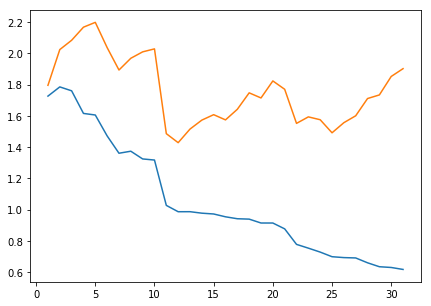

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

# find the best linkage

err_cal = np.zeros((nbin-1,))
err_cv = np.zeros((nbin-1,))
mean_y_st = np.mean(y_st)

for ii in xrange(nbin-1):
    linreg = LinearRegression()
    linreg.fit(red_cal[:,:(ii+1)], y_st_cal)
    y_st_cal_pred = linreg.predict(red_cal[:,:(ii+1)])
    err_cal[ii] = 100*np.mean(np.abs(y_st_cal_pred-y_st_cal)/mean_y_st)

    y_st_cv_pred = cross_val_predict(linreg, red_cal[:,:(ii+1)], y_st_cal, cv=nc*n_class) 
    err_cv[ii] = 100*np.mean(np.abs(y_st_cv_pred-y_st_cal)/mean_y_st)

plt.figure(figsize=[7, 5])
plt.plot(np.arange(nbin-1)+1, err_cal)
plt.plot(np.arange(nbin-1)+1, err_cv)

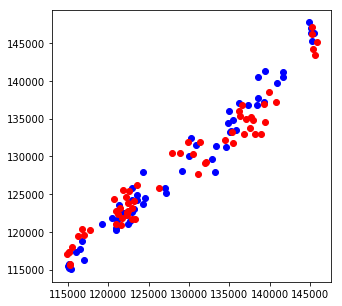

In [16]:
npc = 12

linreg = LinearRegression()
linreg.fit(red_cal[:,:npc], y_st_cal)

y_st_cal_pred = linreg.predict(red_cal[:,:npc])
y_st_val_pred = linreg.predict(red_val[:,:npc])

plt.figure(figsize=[5, 5])
plt.scatter(y_st_cal, y_st_cal_pred, c='b')
plt.scatter(y_st_val, y_st_val_pred, c='r')
